## Stroke Prediction Project

### Introduction To Project

According to the World Health Organization (WHO), stroke is the 2nd leading
cause of death globally, responsible for approximately 11% of total deaths.
Early detection is key to minimizing complications.

This project involves an exploration of the Stroke Prediction Dataset,
applying statistical inference procedures, and uses various machine learning
models to make effective predictions. The ultimate goal is to deploy a model
that aids in real-time stroke prediction, improving healthcare outcomes.

[KAGGLE stroke dataset link](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

### Data Preparation

In [86]:
import pandas as pd
import numpy as np
import random
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
)

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import shap
import eli5

import joblib


In [87]:
#importing our data
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
print(df.shape)
df.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Attribute Information
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [88]:
# Rename column to have all in lowercase
df = df.rename(columns={"Residence_type": "residence_type"})

In [89]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


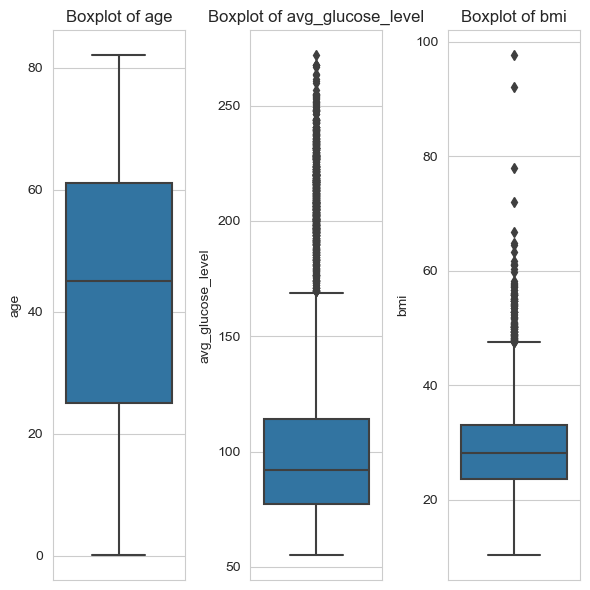

In [90]:
# Create a list of the columns you want to plot
columns = ['age', 'avg_glucose_level', 'bmi']

# Create subplots of boxplot
fig, axs = plt.subplots(1, 3, figsize=(6,6))
for i, column in enumerate(columns):
    sns.boxplot(y=df[column], ax=axs[i])
    axs[i].set_title('Boxplot of '+column)

plt.tight_layout()
plt.show()

In our describe table and boxplots we can't see any anomalies or impossible
values. There are some outliers in BMI boxplot, but values are possible.

In [91]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [92]:
df[df['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


Here we can see that we have only one row with gender "Other". ML models
based on patterns and single row wouldn't have significant impact and
should treat it like a noise and ignore it. I have decided to remove this row.
This decision is purely based on analytical clarity and does not diminish the
importance of recognizing diverse gender identities in data collection and
analysis.

In [93]:
df.drop(df[df['gender'] == 'Other'].index, inplace=True)

In [94]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

As we can see, there are missing values in BMI column. We will use KNN
imputer to fill these values. Firstly, we need to create a temporary dataframe
to encode our data to numeric values.

In [95]:
# Set the random seed to get the same results
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

df_knn_impute = df.copy()

# mapping values in smoking_status columns
smoking_status_order = {
    'never smoked': 0,
    'formerly smoked': 1,
    'smokes': 2,
    'Unknown': 3
}

df_knn_impute['smoking_status'] = df_knn_impute['smoking_status'].map(smoking_status_order)

# using label encoder to encode these columns in le_cols list
le_cols = ['gender', 'work_type', 'residence_type','ever_married']
le = LabelEncoder()

for column in le_cols:
    df_knn_impute[column] = le.fit_transform(df_knn_impute[column])

In [96]:
# instance and apply of KNNImputer to the whole dataframe
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df_knn_impute)

# Convert the imputed data back to a pandas DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

df.reset_index(drop=True, inplace=True)
df['bmi'] = df_imputed['bmi']

In [97]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [98]:
df.duplicated().sum()

0

As we can see, there are no missing values and duplicates left. Our id column
 doesn't provide any useful information, so we should remove it.

In [99]:
df.drop('id', axis=1, inplace=True)

### Data Analysis

The Main goal of this analysis is to get insights about people who had a stroke
and what could be reasons for that.
To begin with, we should check how many people had stroke.

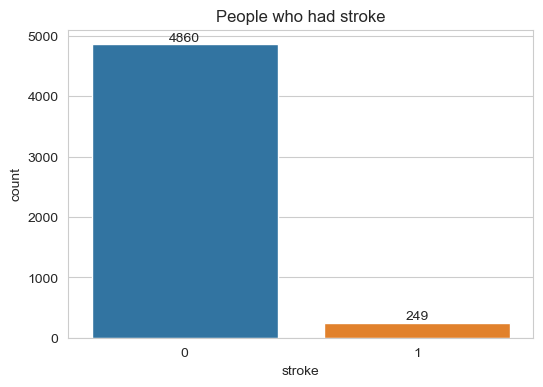

In [100]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="stroke", data=df)
ax.bar_label(ax.containers[0])
plt.title("People who had stroke")
plt.show();

Here we can see we have very imbalanced data. There are 4861 people who
didn't have a stroke and 249 who had. It is almost 5%

Stroke happen when a blood clot blocks the flow of blood and oxygen to the
brain.

These blood clots typically form in areas where the arteries have been
narrowed or blocked over time by fatty deposits (plaques). This process is
known as atherosclerosis.

Your arteries may naturally become narrower as you age, but there are some
things that dangerously speed up this process.

These include:

* smoking
* high blood pressure (hypertension)
* obesity
* high cholesterol levels
* diabetes
* excessive alcohol intake
* Another possible cause of ischaemic stroke is a type of irregular
  heartbeat called atrial fibrillation.

[SOURCE: https://www.nhs.uk/conditions/stroke/causes/](https://www.nhs.uk/conditions/stroke/causes/)

We should is there correlation in between our features, for better feel of
the dataset.

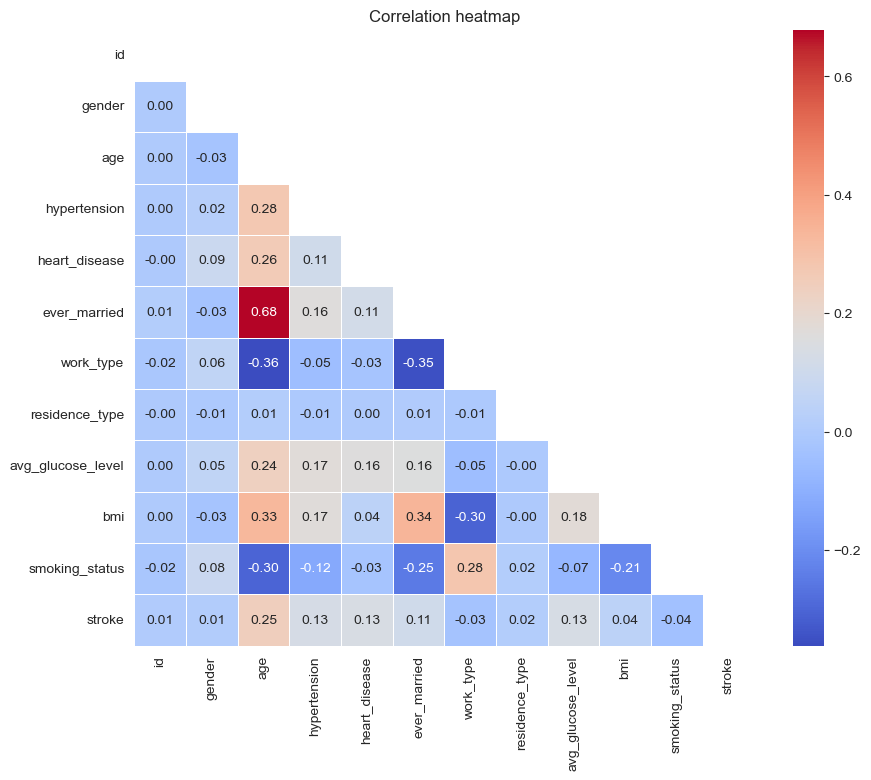

In [101]:
# Calculate the correlation matrix
corr_matrix = df_knn_impute.corr()

# Create a mask to hide the upper triangle of the correlation matrix
# (which is mirrored)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            mask=mask,
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            linewidths=.5)
plt.title('Correlation heatmap')
plt.show()

In a correlation matrix, we cannot see any very strong correlations except
marriage status and age, marriage status shouldn't have impact to stroke. We
can observe a little positive correlation in age and stroke, but it is not
very strong. Most of the features have binary values, so it will not show
relevant insights.

As arteries may naturally become narrower as you age, we should check age
distributions

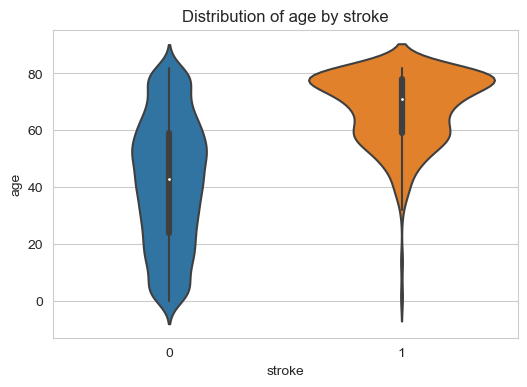

In [102]:
def violin_plot_hue(feature, hue, df=df):
    """Function make violin plots for feature"""
    plt.figure(figsize=(6,4))
    sns.violinplot(x=feature, y=hue, data=df)
    plt.title(f'Distribution of {hue} by {feature}')
    plt.xlabel(feature)
    plt.ylabel(hue)

violin_plot_hue('stroke','age')

Here violin plots show that people over 55years old have a tendency to get
stroke more often. People at that age should be more aware as their arteries
 are getting narrower as getting older.
Another thing that can have an impact on artery narrowing is smoking.

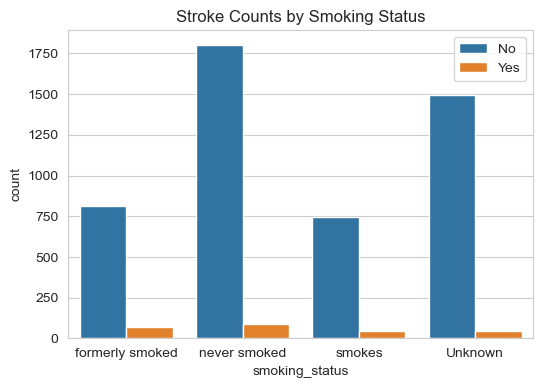

In [103]:
plt.figure(figsize=(6,4))
sns.countplot(x="smoking_status", hue="stroke", data=df)
plt.legend(["No", "Yes"])
plt.title('Stroke Counts by Smoking Status')
plt.show()


There we can see values of unknown smoking status, we should eliminate it as
 it doesn't give any relevant information, and get proportions of other values.

<Figure size 600x400 with 0 Axes>

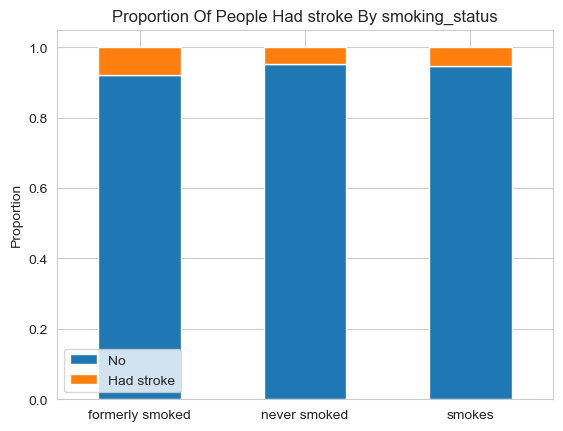

In [104]:
# Filter out 'Unknown' smoking status as it didn't provide any insights
df_filtered = df[df['smoking_status'] != 'Unknown']

def plotting_proportions(feature, hue, df=df):
    """Creates a stacked plot, of proportions by feature"""

    # Create a DataFrame with proportions
    proportions = df.groupby(feature)[hue]\
                    .value_counts(normalize=True).unstack()

    # Plotting proportions
    plt.figure(figsize=(6,4))
    proportions.plot(kind='bar', stacked=True)
    plt.title(f'Proportion Of People Had {hue} By {feature}')
    plt.legend(["No", "Had stroke"])
    plt.xlabel('')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)
    plt.show()


plotting_proportions('smoking_status', 'stroke', df_filtered)

As we can see, stroke proportions by smoking status don't look very different.
We should make hypothesis testing to see if there is a significant difference.

**Population:** Patients in the stroke prediction dataset.

**Parameter of Interest:** $p_{non-smoker} - p_{ex-smoker} -
p_{current-smoker}$,  difference of proportions.

**Null Hypothesis $H_0$:** $H_0: p_{non-smoker} = p_{ex-smoker} = p_{current-smoker}$
The proportion of people who had a stroke is the same across non-smokers,
ex-smokers, and current smokers.

**Alternative Hypothesis $H_a$:** $H_A: p_{non-smoker} \ne p_{ex-smoker} \ne p_{current-smoker}$
The proportion of people who had a stroke is significantly different across
 non-smokers, ex-smokers, and current smokers.

We will set a confidence level of 95%:
**$\alpha = 0.05$**

In [105]:
# Create contingency table
contingency_table = pd.crosstab(df_filtered['smoking_status'],
                                df_filtered['stroke'])
# Perform chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"The p-value of the test is {p_val:.5f}")

The p-value of the test is 0.00320


Since p-value is less than 0.05, we can reject our null hypothesis and assume
that the proportion of people who had a stroke is significantly different across
non-smokers, ex-smokers, and current smokers.

In our graphs, we can see that former smokers have a bigger proportion of
 strokes than smokers. It might be because of their difference in their age.
To see why it can be like that, we should check age distribution by smoking
status

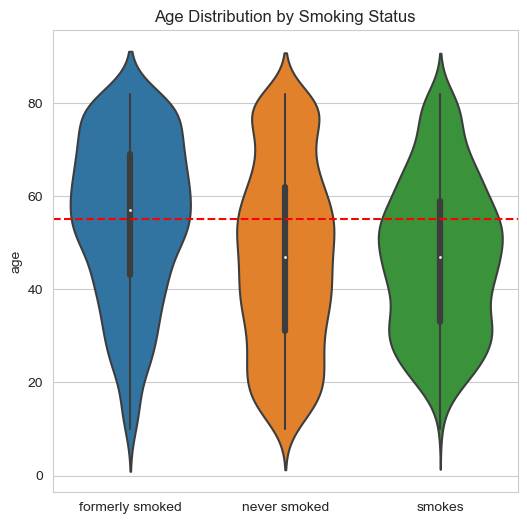

In [106]:
plt.figure(figsize=(6, 6))
sns.violinplot(x='smoking_status', y='age', data=df_filtered)
plt.title('Age Distribution by Smoking Status')
plt.xlabel('')
plt.axhline(y=55, color='r', linestyle='--')
plt.show();

The majority of current smokers are below 60 years old, while former smokers
tend to be around 55 or older. This could indicate that people tend to quit
smoking as they age. As age is quite important factor to stroke risk, it
could explain our proportions of smoking status and risk of stroke.

Another feature we should check is average glucose level

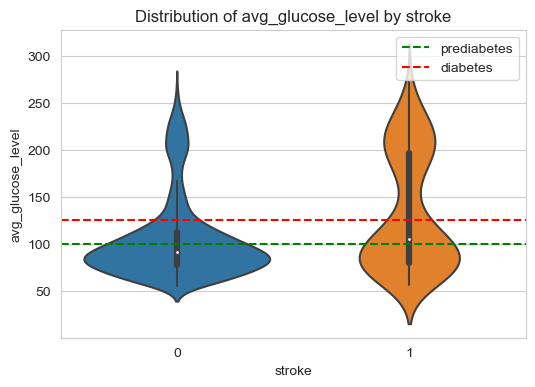

In [107]:
violin_plot_hue('stroke','avg_glucose_level')
# Adding horizontal lines, diabetes and prediabetes thresholds
plt.axhline(y=100, color='g', linestyle='--', label='prediabetes')
plt.axhline(y=125, color='r', linestyle='--', label='diabetes')
plt.legend();


A fasting blood sugar level of 99 mg/dL or lower is normal; 100 to 125 mg/dL
indicates you have prediabetes, and 126 mg/dL or higher indicates you have
diabetes.  [SOURCE: https://www.cdc.gov/diabetes/basics/getting-tested.html](https://www.cdc.gov/diabetes/basics/getting-tested.html)
As blood sugar level can have impact to stroke, we can see most of the people
had stroke without having diabetes and having normal sugar levels. We should
  check the proportions of people who got diabetes and who don't

<Figure size 600x400 with 0 Axes>

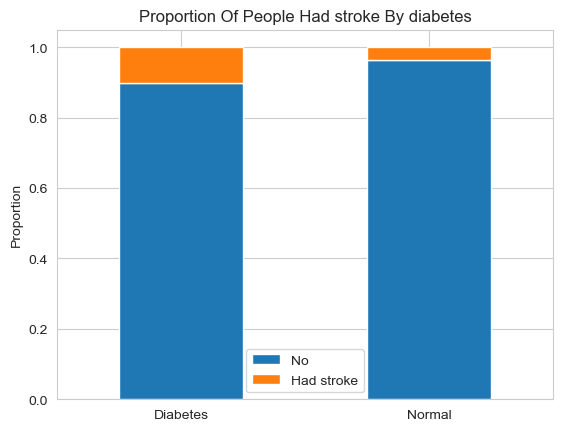

In [108]:
# Create a new column to indicate if a patient has diabetes
df['diabetes'] = df['avg_glucose_level']\
                .apply(lambda x: 'Diabetes' if x > 125 else 'Normal')

plotting_proportions('diabetes', 'stroke', df)

Here we can see that people with diabetes have a higher proportion of stroke
incidents. To make sure that difference is significant, we can perform
hypothesis test:

**Population:** Patients in the Stroke Prediction Dataset

**Parameter of Interest:** $p_{diabetes} - p_{non-diabetes}$, difference of
proportions.

**Null Hypothesis $H_0$:** $p_{diabetes} = p_{non-diabetes}$
The proportion of patients who had a stroke is the same in both diabetes and
non-diabetes groups.

**Alternative Hypothesis $H_a$:** $p_{diabetes} \ne p_{non-diabetes}$
The proportion of patients who had a stroke is significantly different between
 the diabetes and non-diabetes groups.

We will set a confidence level of 95%:
**$\alpha = 0.05$**

In [109]:
# Create a contingency table
contingency_table = pd.crosstab(df['diabetes'], df['stroke'])

# Perform Chi-square test
chi2, p_val, _, _ = chi2_contingency(contingency_table)
print(f"The p-value of the test is {p_val:.5f}")

The p-value of the test is 0.00000


Since p_value is less than 0.05, we can assume that the proportion of
patients who had a stroke is significantly different between the diabetes
and non-diabetes groups.

One of the factors who can develop diabetes is overweight. While obesity and
high cholesterol levels can have an impact on stroke prediction, we should
check our patients' BMI. **BMI = kg/m2**

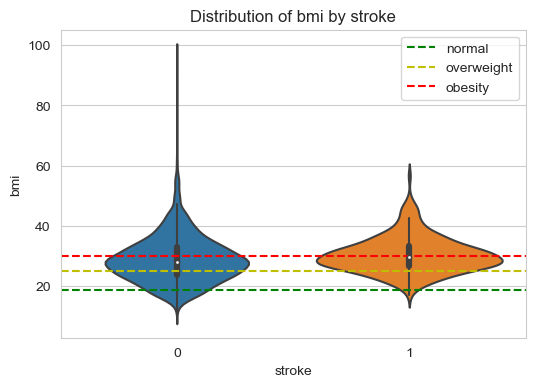

In [110]:
violin_plot_hue('stroke','bmi')
# Adding horizontal lines, BMI thresholds
plt.axhline(y=18.5, color='g', linestyle='--', label='normal')
plt.axhline(y=24.9, color='y', linestyle='--', label='overweight')
plt.axhline(y=29.9, color='r', linestyle='--', label='obesity')
plt.legend();

BMI	Weight Status
Below 18.5	  Underweight
18.5–24.9	  Healthy Weight
25.0–29.9	  Overweight
30.0 or more  Obesity
[SOURCE](https://www.cdc.gov/obesity/basics/adult-defining.html)
From a graph above we can see that a lot of patients have an overweight or
obesity. We should categorize them and see if there is a difference in
proportions in each group.


<Figure size 600x400 with 0 Axes>

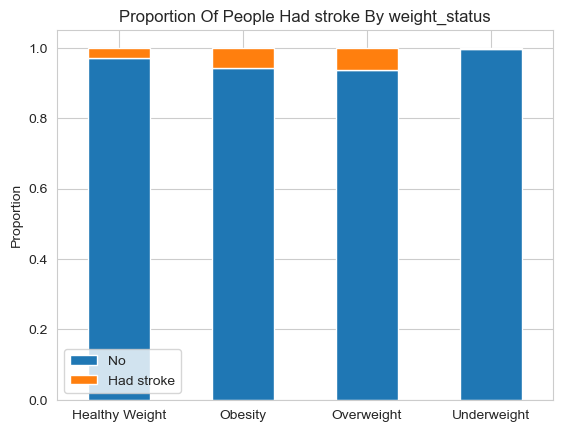

In [111]:
def categorize_bmi(bmi):
    """Function to categorize bmi to weight status"""
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Healthy Weight'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obesity'

df['weight_status'] = df['bmi'].apply(categorize_bmi)

plotting_proportions('weight_status', 'stroke', df)

Here we can see that patients with overweight or obesity have higher stroke
risk. People with healthy weight have almost twice less probability to get a
stroke, and underweight individuals seem to have minimal stroke risk.

Last feature left to check is hypertension.


<Figure size 600x400 with 0 Axes>

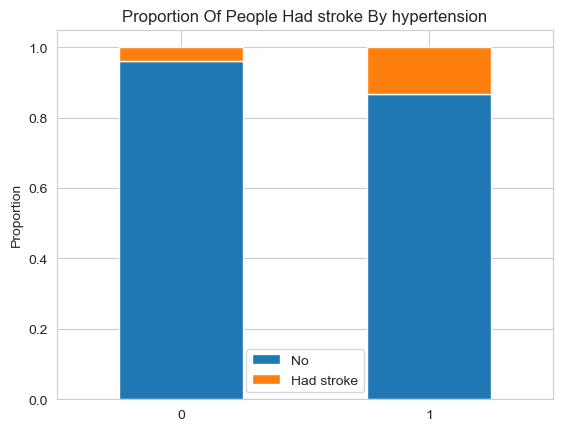

In [112]:
plotting_proportions('hypertension', 'stroke', df)

The group with hypertension demonstrates a higher risk of stroke. It's
necessary to pay attention to this feature in our analysis.

### Machine Learning Predictions

In this part, we are going to predict patients with higher risk of getting
stroke

#### Feature Engineering

In [113]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,diabetes,weight_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,Diabetes,Obesity
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.08,never smoked,1,Diabetes,Overweight
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,Normal,Obesity
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,Diabetes,Obesity
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,Diabetes,Healthy Weight


In [114]:
# Creating a new column to mark where smoking status is unknown
df['smoking_unknown'] = df['smoking_status']\
    .apply(lambda x: 1 if x=='Unknown' else 0)

# Binning age to categories
def categorize_age(age):
    """Function to categorize age"""
    if age < 35:
        return 'Young'
    elif age < 55:
        return 'Middle age'
    else:
        return 'Senior'

df['age_group'] = df['age'].apply(categorize_age)

In [115]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,diabetes,weight_status,smoking_unknown,age_group
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,Diabetes,Obesity,0,Senior
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.08,never smoked,1,Diabetes,Overweight,0,Senior
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,Normal,Obesity,0,Senior
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,Diabetes,Obesity,0,Middle age
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,Diabetes,Healthy Weight,0,Senior


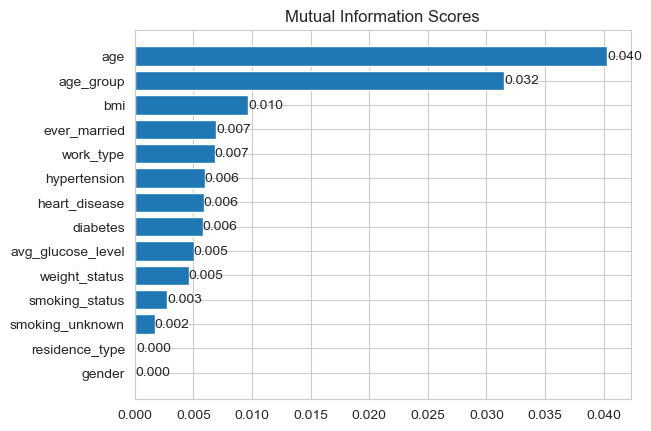

In [116]:
from pandas import DataFrame, Series
def make_mi_scores(X: DataFrame, y: Series) -> Series:
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    # Add the data value on each bar
    for idx, value in enumerate(scores.sort_values()):
        plt.text(value, idx, f'{value:.3f}', va='center')
    plt.show()

# Get features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores)


Features with higher MI score indicate relationship between feature and
target variable. Age, age_group, bmi have the strongest relationships with
stroke variable. For some models, highly correlated features can cause
problems, but tree-based models like Random Forests and gradient boosting
can handle correlations pretty well. As residence_type and gender mi_score
is 0, we should remove it. As well  other features with MI values less than
0.003

In [117]:
cols_to_drop = ['residence_type','gender','ever_married','smoking_unknown',
                'smoking_status']
df.drop(columns=cols_to_drop, axis=1, inplace=True)

# Get features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Splitting dataset to training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3,
                                                    stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5,
                                                stratify=y_temp)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3576, 9)
(766, 9)
(767, 9)


#### Model Selection

At first, we should create pipelines for data preprocessor and model selection.

In [118]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
           ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant")),
        ("encoder", OneHotEncoder())
    ]
)

categories = [
    ['Underweight', 'Healthy Weight', 'Overweight', 'Obesity'], # weight_status
    ['Young', 'Middle age', 'Senior']                           # age_group
]
ordinal_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant")),
        ("encoder", OrdinalEncoder(categories=categories))
    ]
)

In [119]:
# Selecting numeric and categorical features. Assigning them to preprocessor
# pipeline.
numeric_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = [
    'hypertension',
    'heart_disease',
    'work_type',
    'diabetes'
]
ordinal_features = ['weight_status','age_group']
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
        ('ordinal', ordinal_transformer, ordinal_features)
    ]
)

After that we need to write a list of classifiers that we want to train and
make a loop for training them and making dataframe of their metrics.

In [120]:
classifiers = [
    LogisticRegression(),
    SVC(probability=True),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    BaggingClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(eval_metric="mlogloss"),
    LGBMClassifier(),
    CatBoostClassifier(verbose=False)
]

results = []

for classifier in classifiers:
    start_time = time.time()

    # Define the pipeline
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("smote", SMOTE()),
            ("classifier", classifier),
        ]
    )

    # Fit and predict
    model = pipeline.fit(X_train, y_train)
    predictions = model.predict(X_val)
    probabilities = model.predict_proba(X_val)[:, 1] # for roc_auc_score

    end_time = time.time()

    # Compute metrics
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    roc_auc = roc_auc_score(y_val, probabilities)
    time_elapsed = end_time - start_time

    results.append({
        'Classifier': type(classifier).__name__,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC AUC': roc_auc,
        'Time (s)': time_elapsed
    })
    print(type(classifier).__name__ + ' trained successfully in '
          + f"{time_elapsed:.3f}" + ' s')

results_df = pd.DataFrame(results)

results_df


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression trained successfully in 0.169 s
SVC trained successfully in 20.980 s
RandomForestClassifier trained successfully in 1.975 s
KNeighborsClassifier trained successfully in 0.264 s
DecisionTreeClassifier trained successfully in 0.250 s
BaggingClassifier trained successfully in 0.843 s
AdaBoostClassifier trained successfully in 1.077 s
GradientBoostingClassifier trained successfully in 2.318 s
XGBClassifier trained successfully in 0.809 s
LGBMClassifier trained successfully in 0.406 s
CatBoostClassifier trained successfully in 9.476 s


,Classifier,Accuracy,Precision,Recall,F1,ROC AUC,Time (s)
0,LogisticRegression,0.715405,0.118143,0.756757,0.204380,0.818596,0.169000
1,SVC,0.693211,0.110236,0.756757,0.192440,0.796055,20.979971
2,RandomForestClassifier,0.886423,0.109375,0.189189,0.138614,0.746765,1.974972
3,KNeighborsClassifier,0.810705,0.102941,0.378378,0.161850,0.662348,0.264062
4,DecisionTreeClassifier,0.870757,0.112500,0.243243,0.153846,0.572925,0.249715
5,BaggingClassifier,0.896867,0.137931,0.216216,0.168421,0.710525,0.843350
6,AdaBoostClassifier,0.750653,0.118812,0.648649,0.200837,0.778149,1.077001
7,GradientBoostingClassifier,0.795039,0.125000,0.540541,0.203046,0.777073,2.318025
8,XGBClassifier,0.924282,0.161290,0.135135,0.147059,0.764320,0.808570
9,LGBMClassifier,0.919060,0.121212,0.108108,0.114286,0.778890,0.405998


In a table above, we can see the results of models with default settings. In our
problem, we should get as many true positives as we can and False negatives
should be minimized. In that case we are looking for best recall scores. But
minimizing False Positives is important as well, so we will choose these
for hyperparameter tuning.
* Logistic regression Recall 0.76, ROC_AUC 0.82
* AdaBoostClassifier Recall 0.65, ROC_AUC 0.78

SVC performed good as well, but training time is too long.


In [121]:
param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [10,50,100,250,500,1000],
    'classifier__solver': ['liblinear']
}
param_grid_ada = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate' : [0.01,0.05,0.1,0.3,1],
    'classifier__algorithm' : ['SAMME', 'SAMME.R']
}

classifiers = [
    {"classifier": LogisticRegression(), "param_grid": param_grid_lr},
    {"classifier": AdaBoostClassifier(), "param_grid": param_grid_ada}
]


# Remaining code as before


for clf in classifiers:
    start_time = time.time()
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("smote", SMOTE()),
            ("classifier", clf["classifier"]),
        ]
    )

    randomized_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=clf["param_grid"],
        scoring="recall",
        n_iter=80,
        cv=5,
        n_jobs=-1,
        random_state=42,
    )

    randomized_search.fit(X_train, y_train)
    best_estimator = randomized_search.best_estimator_

    predictions = best_estimator.predict(X_val)
    recall = recall_score(y_val, predictions)
    roc_auc = roc_auc_score(y_val, predictions)
    end_time = time.time()

    print(clf["classifier"].__class__.__name__)
    print("ROC_AUC :", roc_auc)
    print("Recall :", recall)
    print("Time: ", end_time - start_time)
    print("Best parameters:", randomized_search.best_params_)
    print("***")


LogisticRegression
ROC_AUC : 0.6921736551366181
Recall : 0.8918918918918919
Time:  22.50082802772522
Best parameters: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__max_iter': 10, 'classifier__C': 0.001}
***


The total space of parameters 30 is smaller than n_iter=80. Running 30 iterations. For exhaustive searches, use GridSearchCV.


AdaBoostClassifier
ROC_AUC : 0.6833870907944982
Recall : 0.7837837837837838
Time:  37.44473671913147
Best parameters: {'classifier__n_estimators': 200, 'classifier__learning_rate': 0.01, 'classifier__algorithm': 'SAMME'}
***


We used RandomizedSearchCV by ROC_AUC score to find the best hyperparameters.
***
LogisticRegression
ROC_AUC : 0.72
Recall : 0.76
Time: 37.372
Best parameters: {
'solver': 'liblinear',
'penalty': 'l2',
'max_iter': 250,
'C': 0.01}
***
AdaBoostClassifier
ROC_AUC : 0.73
Recall : 0.78
Time: 63.32
Best parameters: {
'n_estimators': 50,
'learning_rate': 0.05,
'algorithm': 'SAMME.R'}
***
As we get almost the same results, let's compare both models on test data

Logistic Regression:


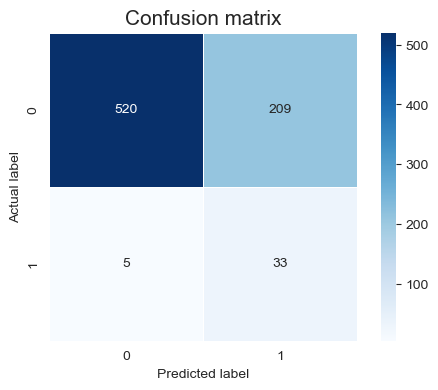


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.71      0.83       729
           1       0.14      0.87      0.24        38

    accuracy                           0.72       767
   macro avg       0.56      0.79      0.53       767
weighted avg       0.95      0.72      0.80       767

AdaBoost:


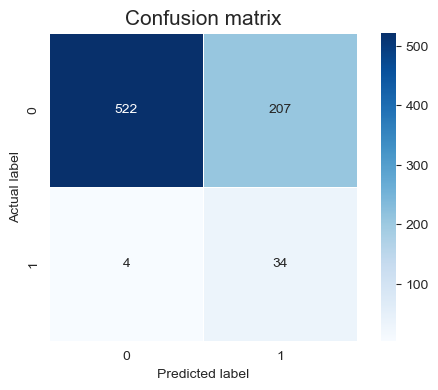


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.72      0.83       729
           1       0.14      0.89      0.24        38

    accuracy                           0.72       767
   macro avg       0.57      0.81      0.54       767
weighted avg       0.95      0.72      0.80       767


In [122]:
# Define two separate pipelines
pipeline_logreg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE()),
        ("classifier", LogisticRegression(C=0.01,
                                          max_iter=250,
                                          penalty='l1',
                                          solver='liblinear'))
    ]
)

pipeline_ada = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE()),
        ("classifier", AdaBoostClassifier(n_estimators=50,
                                          learning_rate=0.05,
                                          algorithm='SAMME.R'))
    ]
)

# Concatenate the training and validation sets
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Fit and predict using a Logistic Regression pipeline
log_reg_model = pipeline_logreg.fit(X_train_val, y_train_val)
log_reg_predictions = log_reg_model.predict(X_test)

# Creating function, which creates confusion matrix
def conf_matrix_pred(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".0f",
        linewidths=0.5,
        cmap="Blues",
        square=True,
    )
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    all_sample_title = "Confusion matrix"
    plt.title(all_sample_title, size=15)
    plt.show()

# Display confusion matrix and classification report
print("Logistic Regression:")
conf_matrix_pred(y_test, log_reg_predictions)
print("\nClassification Report:\n",
      classification_report(y_test, log_reg_predictions, zero_division=0))

# Fit and predict using AdaBoost pipeline
ada_model = pipeline_ada.fit(X_train_val, y_train_val)
ada_predictions = ada_model.predict(X_test)

# Display confusion matrix and classification report
print("AdaBoost:")
conf_matrix_pred(y_test, ada_predictions)
print("\nClassification Report:\n",
      classification_report(y_test, ada_predictions, zero_division=0))


After training model on training and validating data both models performed
almost identical, Logistic regression gets 3more of True Negatives and 3 less
 of False Positives. We get recall 0.89.
That means we can predict 89 % of people who had stroke. But our precision score
is just 14%; that means only 14% of cases predicted as stroke actually had a
stroke.
In this problem, minimizing false negatives is prioritized. But the high
number of false positives indicates our model need for improvement.
As our False Positives mean unnecessary treatments and tests which can cost
 a lot. We could try to adjust a threshold.


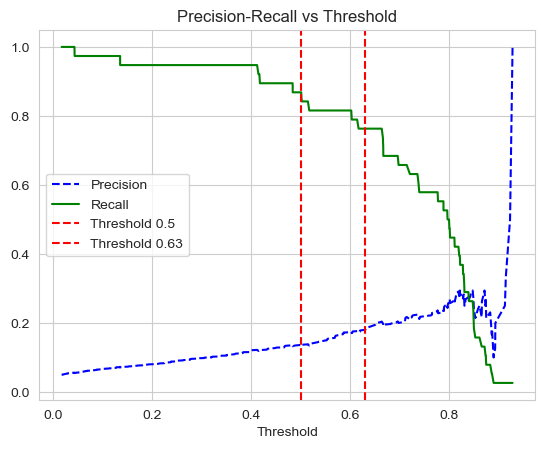

In [123]:
# Get the probabilities of the positive class
y_scores = log_reg_model.predict_proba(X_test)[:, 1]

# Calculate precision and recall values
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """Draws a Precision-Recall vs Threshold plot"""
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.axvline(x=0.50, color="r", linestyle="--", label="Threshold 0.5")
    plt.axvline(x=0.63, color="r", linestyle="--", label="Threshold 0.63")
    plt.xlabel("Threshold")
    plt.title("Precision-Recall vs Threshold")
    plt.legend()
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

We can try to move the threshold from 0.5 to 0.64 before that strong recall drop
 to adjust precision with a minimal recall drop.

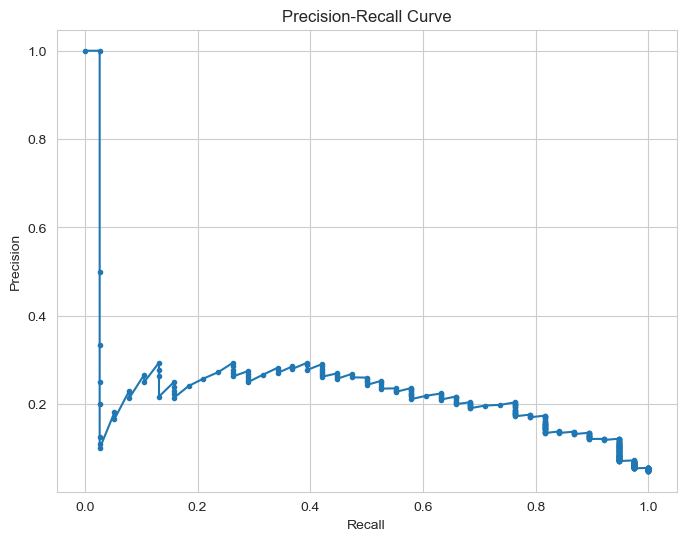

In [124]:
# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

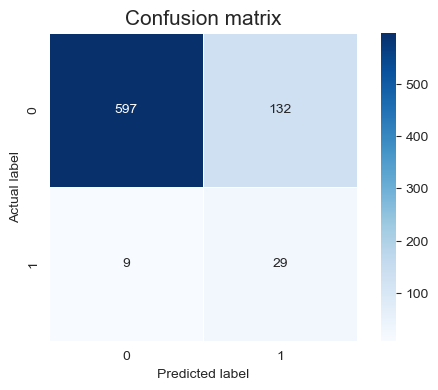


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.89       729
           1       0.18      0.76      0.29        38

    accuracy                           0.82       767
   macro avg       0.58      0.79      0.59       767
weighted avg       0.95      0.82      0.86       767


In [125]:
# Generate probabilities for positive class
y_probs = log_reg_model.predict_proba(X_test)[:, 1]

# Choose a threshold
threshold = 0.63

# Filter our predictions by threshold
log_reg_predictions_threshold = [1 if prob >= threshold else 0 for prob in
                              y_probs]
conf_matrix_pred(y_test, log_reg_predictions_threshold)

print(
    "\nClassification Report:\n",
    classification_report(y_test, log_reg_predictions_threshold, zero_division=0),
)

With adjusted threshold our recall dropped from 89% to 82% but precision
increased from 14% to 18%. Overall accuracy increased from 72% to 81% but as
our data is very imbalanced, it is not very good metric. The optimal threshold
should be chosen based on specific needs and goals. If it is very important
not to miss any stroke cases lower threshold might be better choice.

We should check what features have impact on our model predictions.


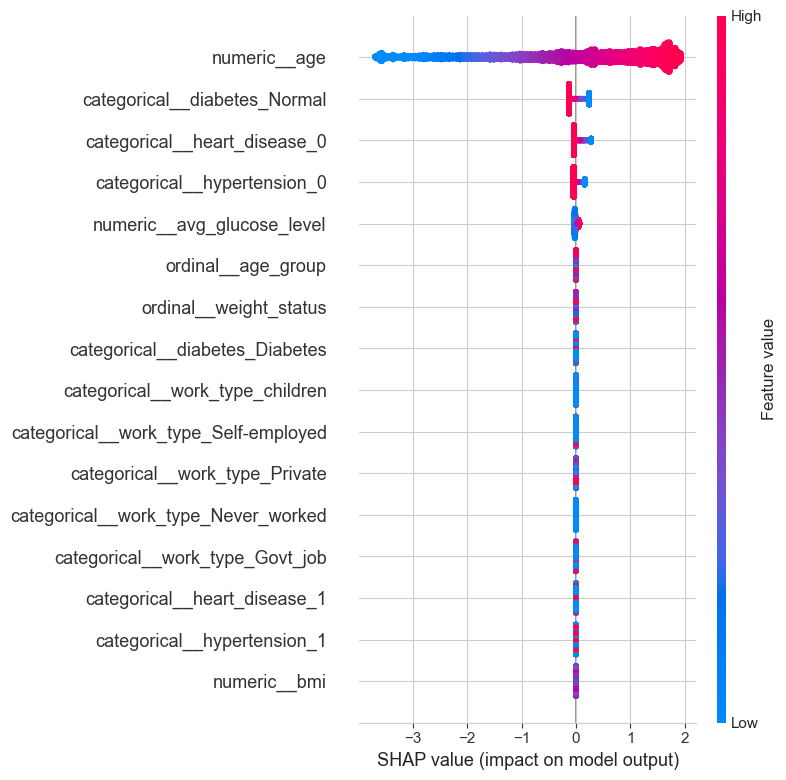

In [126]:
# Apply preprocessing
preprocessor = pipeline_logreg.named_steps["preprocessor"]
X_train_val_preprocessed = preprocessor.transform(X_train_val)

# Apply SMOTE
smote = pipeline_logreg.named_steps["smote"]
X_train_val_preprocessed, y_train_val_resampled = smote.fit_resample(X_train_val_preprocessed, y_train_val)

# Fit the classifier on preprocessed data
classifier = pipeline_logreg.named_steps["classifier"]
classifier.fit(X_train_val_preprocessed, y_train_val_resampled)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

# Create a SHAP explainer
explainer = shap.LinearExplainer(classifier,
                                 X_train_val_preprocessed,
                                 feature_names=feature_names)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_val_preprocessed)

# Summary plot
shap.summary_plot(shap_values,
                  X_train_val_preprocessed,
                  feature_names=feature_names)

Different features have different impact to model predictions. In that case
most important features is age, age_group, diabetes and hypertension.

In [127]:
print(feature_names)
eli5.show_weights(classifier, feature_names=feature_names)

['numeric__age' 'numeric__avg_glucose_level' 'numeric__bmi'
 'categorical__hypertension_0' 'categorical__hypertension_1'
 'categorical__heart_disease_0' 'categorical__heart_disease_1'
 'categorical__work_type_Govt_job' 'categorical__work_type_Never_worked'
 'categorical__work_type_Private' 'categorical__work_type_Self-employed'
 'categorical__work_type_children' 'categorical__diabetes_Diabetes'
 'categorical__diabetes_Normal' 'ordinal__weight_status'
 'ordinal__age_group']


Weight?,Feature
+1.550,numeric__age
+0.021,numeric__avg_glucose_level
-0.166,<BIAS>
-0.204,categorical__hypertension_0
-0.318,categorical__heart_disease_0
-0.369,categorical__diabetes_Normal


Here we can see how much weight each feature has to our prediction

In [128]:
# Save model
joblib.dump(log_reg_model, 'log_reg.pkl')

['log_reg.pkl']

### Summary

**Insights from the data analysis:**

* The dataset was heavily imbalanced, with 5% of individuals having
experienced a stroke.
* People over the age of 60 have a higher risk of stroke, making age a
significant factor.
* People having diabetes have a bigger chance of getting stroke
* People with overweight and obesity have a higher risk
* Individuals with hypertension also had a higher likelihood of experiencing
a stroke.

**Model training and evaluation:**

Various classification models were trained to predict the likelihood of an
individual having a stroke. The Logistic Regression model achieved the best
performance, with high recall values, indicating good performance in both
identifying true positives and minimizing false negatives. Bus there was a
lot of false positives.

**Business consideration:**

In the healthcare setting, we aim to maximize True Positives (correctly
identifying those who had a stroke) while minimizing False Negatives
(identified as not having a stroke while they had). This is because the cost
of a False Negative could potentially be a person's life.

High False Negative numbers would mean that stroke victims
may not receive the necessary care and attention. Conversely, False
Positives represent individuals who are incorrectly identified as having
a stroke, leading to unnecessary medical interventions and costs.

The threshold of the model can be adjusted to ensure an optimal
balance between True Positives and False Negatives.

**To improve:**

* More data could be helpful, especially data about individuals who have had
a stroke, to balance the dataset and provide more information for the model
to learn from.
* Additional features could also be beneficial, such as more
detailed medical history, lifestyle factors, or genetic information, habits.